In [15]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [16]:
n_samples=1000
data, _ = make_moons(n_samples=1000, noise=0.05)

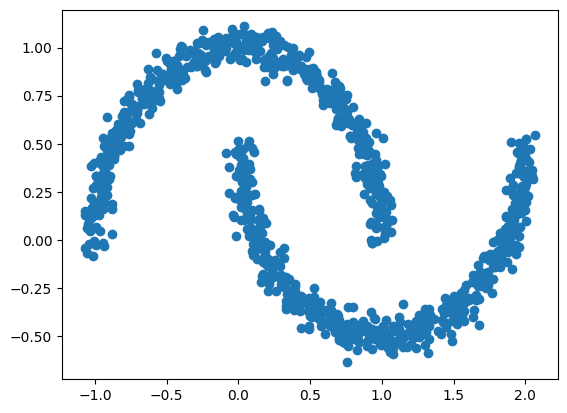

In [18]:
fig=plt.scatter(data[:,0], data[:,1])